In [1]:
import ollama
import PyPDF2

In [2]:
# Define constants
LANGUAGE_MODEL = 'tinyllama:latest'
EMBEDDING_MODEL = 'hf.co/CompendiumLabs/bge-base-en-v1.5-gguf'

In [6]:
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ''
        for page in pdf_reader.pages:
            text += page.extract_text() + '\n'
    return text

celtic_knots_pdf = '../knot theory/celtic_knots.pdf'
protiens_pdf = '../knot theory/protiens.pdf'
quantum_computing_pdf = '../knot theory/quantum_computing.pdf'

celtic_knots_text = extract_text_from_pdf(celtic_knots_pdf)
protiens_text = extract_text_from_pdf(protiens_pdf)
quantum_computing_text = extract_text_from_pdf(quantum_computing_pdf)

dataset = [celtic_knots_text, protiens_text, quantum_computing_text]

In [7]:
# Calculate Chunk Embeddings
vector_db = []

def add_chunk_to_db(chunk):
    embedding = ollama.embed(EMBEDDING_MODEL, chunk)['embeddings'][0]
    vector_db.append((chunk, embedding))

In [9]:
# Split data to chunks and add to db
def split_to_chunks(dataset):
    for document in dataset:
        chunks = document.split('.')
        for i, chunk in enumerate(chunks):
            if chunk:
                add_chunk_to_db(chunk)
        print(f'Added {i+1} chunks to the db.')

In [10]:
split_to_chunks(dataset)

Added 701 chunks to the db.
Added 616 chunks to the db.
Added 414 chunks to the db.


In [18]:
from numpy import size


print(len(vector_db), type(vector_db))
print(len(vector_db[0]))
print(vector_db[0])

1970 <class 'list'>
2
('CelticGraph : Drawing Graphs as Celtic Knots and\nLinks\nPeter Eades1, Niklas Gröne2, Karsten Klein2[0000−0002−8345−5806], Patrick\nEades5, Leo Schreiber4, Ulf Hailer2, and Falk Schreiber2,3\n1University of Sydney, Australia\n2University of Konstanz, Germany\n3Monash University, Australia\n4Independent Scholar, Germany\n5Melbourne University, Australia\nFig', [0.019742846, 0.004197615, -0.0063937977, -0.005452595, 0.009186944, -0.014509449, 0.013742011, 0.03575844, 0.0040773964, -0.07535537, -0.033040646, -0.032226864, -0.07355995, 0.022622468, 0.021201655, 0.055073682, 0.0367046, 0.017970106, 0.019672748, -0.046335656, 0.008077724, -0.009001786, -0.022814281, 0.022865022, 0.032114767, 0.03851209, 0.03678167, -0.010395852, -0.027235342, 0.016846625, 0.03269661, 0.00018373036, -0.012099436, -0.057804823, 0.01663079, -0.04132753, -0.06368781, 0.009509919, -0.013076385, 0.0014633844, -0.06434751, 0.039046656, 0.029765554, 0.02470222, -0.044181656, 0.0012421164, -0.

In [19]:
# Define cosine similarity
def cosine_similarity(a, b):
    dot_product = sum([x * y for x, y in zip(a, b)])
    norm_a = sum([x ** 2 for x in a]) ** 0.5
    norm_b = sum([x ** 2 for x in b]) ** 0.5
    return dot_product / (norm_a * norm_b)

In [26]:
def calculate_similarities(input_query):
    embedded_query = ollama.embed(LANGUAGE_MODEL, input_query)['embeddings'][0]
    similarities = []
    for chunk, embedding in vector_db:
        similarity = cosine_similarity(embedded_query, embedding)
        similarities.append((chunk, similarity))
    
    return similarities

In [ ]:
# Define Knowledge Retrieval
def retriev(input_query, top_n=3):
    similarities = calculate_similarities(input_query)
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

In [21]:
user_prompt = input('\nSend a message: ')

In [32]:
similarities = calculate_similarities(user_prompt)
similarities = [x[1] for x in similarities] 

In [ ]:
rint(shape())

Text(0, 0.5, 'similarity')

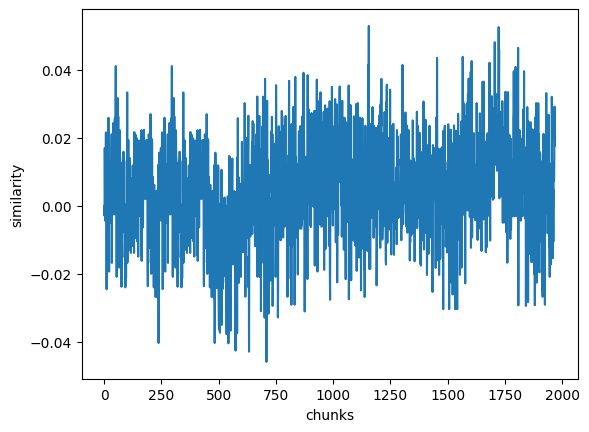

In [33]:
import matplotlib.pyplot as plt

plt.plot(similarities)
plt.xlabel('chunks')
plt.ylabel('similarity')

In [22]:
retrieved_knowledge = retriev(user_prompt, 5)
print('Retrieved knowledge:')
for chunk, similarity in retrieved_knowledge:
    print(f' - (similarity: {similarity:.2f}) {chunk}')

Retrieved knowledge:
 - (similarity: 0.05)  It has turned out to
be a particularly effective means to distinguish knots
 - (similarity: 0.05)  When we have this guarantee we
can measure the value of a qubit simply by fusing a xed pair of anyons within the qubit
 - (similarity: 0.05)  In
the event that they annihilate we consider the qubit to being measured as a j0i, and in the
event that they combine we consider it to be a j1i
 - (similarity: 0.05) ] then some phrases like `Interactive Subjectivity
Frameworks' were invented, and everybody was able to relax and get on with it
 - (similarity: 0.05)  After measuring each of the qubits
we will have a string of bits which we will take to be the result of the computation


In [23]:
# Define System Prompt
system_prompt = """You are a helpful and knowledgeable AI assistant. Your primary goal is to assist users effectively based on the information provided to you.

You have access to external documents which serve as your knowledge base. Use the following retrieved information to answer the user's question accurately and comprehensively:
{retrieved_knowledge_formatted}

Please ensure your responses are:
- Accurate and factually correct based on the provided documents.
- Relevant to the user's query.
- Concise and to the point, avoiding unnecessary jargon.
- Helpful and address the user's needs.

If the retrieved information is insufficient to answer the user's question, acknowledge this and state that you cannot provide a complete answer at this time.
"""

retrieved_knowledge_formatted = '\n'.join([f' - {chunk}' for chunk, similarity in retrieved_knowledge])
system_prompt = system_prompt.format(retrieved_knowledge_formatted=retrieved_knowledge_formatted)

master_prompt = [
    {'role': 'system', 'content': system_prompt},
    {'role': user_prompt}
]

In [24]:
# Get Model's Response
stream = ollama.chat(
    model='tinyllama:latest', 
    messages=[
        {'role': 'user', 'content': user_prompt}
    ], 
    stream=True,
)

for chunk in stream:
    print(chunk['message']['content'], end='', flush=True)

Knot theory is an algebraic concept in topology that involves certain properties of knots, which can be used for solving problems related to quantum computing. In the context of quantum computing, this means that knot theory is being used as a way to design and optimize quantum circuits using quantum bits (qubits), or elementary computational elements, by finding the best ways to assemble and manipulate these qubits in such a way that they can perform specific tasks required for certain types of computation.

In particular, researchers are applying knot theory concepts to design and optimize quantum algorithms that use specific types of qubit interactions, called entanglement, to achieve certain tasks. The goal is to find ways to make these qubits interact with each other in a way that allows for the implementation of specific quantum algorithms, making it easier to solve certain problems using quantum computers.

Knot theory can be used for various applications related to quantum comp